In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lectura de datos

In [130]:
DIR = "/content/drive/MyDrive/Colab Notebooks/Data Mining/TP - Individual/"

df_train = pd.read_csv(DIR + "properati_entrenamiento.csv.zip", index_col="id")

#df_train.head()

df_test = pd.read_csv(DIR + "properati_a_predecir.csv.zip", index_col="id")

df_train = df_train.rename({'lat':'longitud','lon':'latitud'},axis=1)
df_test = df_test.rename({'lat':'longitud','lon':'latitud'},axis=1)

#df_test.head()

# Entendimiento (magia parte 1 -- AID)

# Limpieza y transformación de datos (magia parte 2 -- MD)

## **Eliminamos filas para garantizar IID**

In [131]:
## GARANTIZAMOS IID
print(len(df_train))
df_train = df_train[df_train.l1 == 'Argentina']
df_train = df_train[df_train.operation_type == 'Venta']
df_train = df_train[df_train.property_type.isin(['Departamento','PH'])]
df_train = df_train[df_train.l2.isin(['Capital Federal']) | df_train.l3.isin(['La Plata'])]  #ver igual bien cuales necesito (agregar la plata)
df_train = df_train[df_train.l3 != 'Distrito Audiovisual' ]
df_train = df_train[~(df_train.currency=='ARS')] ## PROVISIORIO DESPUES PASAR A DOLAR

print(len(df_train))

994000
124532


## **Eliminamos columnas indecesarias**

In [132]:
## ELIMINAMOS COLUMNAS QUE NO APORTAN

df_train.drop('ad_type', axis='columns', inplace=True) #ad type es solo propiedad
df_train.drop('l1', axis='columns', inplace=True) #l1 es solo Argentina
df_train.drop('l5', axis='columns', inplace=True) #l5 es nula siempre
df_train.drop('operation_type', axis='columns', inplace=True) #operation_type es venta siempre
df_train.drop('l6',axis='columns', inplace=True)


df_test.drop('ad_type', axis='columns', inplace=True) #ad type es solo propiedad
df_test.drop('l1', axis='columns', inplace=True) #l1 es solo Argentina
df_test.drop('l5', axis='columns', inplace=True) #l5 es nula siempre
df_test.drop('operation_type', axis='columns', inplace=True) #operation_type es venta siempre
df_test.drop('l6', axis='columns', inplace=True) #la columna l6 tiene todos nulos

<ipython-input-132-19d1d185ce43>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop('ad_type', axis='columns', inplace=True) #ad type es solo propiedad
<ipython-input-132-19d1d185ce43>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop('l1', axis='columns', inplace=True) #l1 es solo Argentina
<ipython-input-132-19d1d185ce43>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop('l5', axis='columns', inp

In [133]:
df_train.columns

Index(['start_date', 'end_date', 'created_on', 'longitud', 'latitud', 'l2',
       'l3', 'l4', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'currency', 'price_period', 'title',
       'description', 'property_type'],
      dtype='object')

## **Fechas**

In [134]:
## Corrgimos las fechas de end_date. Hay muchos con fechas inexistentes. Le pongo nulo
print(len(df_train))

df_train['end_date'].value_counts(dropna=False)
df_train.loc[df_train['end_date']=='9999-12-31', 'end_date']= np.nan
df_train["end_date"] = pd.to_datetime(df_train["end_date"])
df_train['end_date_null'] = df_train["end_date"].isnull().astype('int')

df_test['end_date'].value_counts(dropna=False)
df_test.loc[df_test['end_date']=='9999-12-31', 'end_date']= np.nan
df_test["end_date"] = pd.to_datetime(df_test["end_date"])
df_test['end_date_null'] = df_test["end_date"].isnull().astype('int')

df_train['date_Q'] = pd.PeriodIndex(df_train.start_date, freq='Q')
df_test['date_Q'] = pd.PeriodIndex(df_test.start_date, freq='Q')

## Eliminamos la columna created_on porque es redundante
df_train.drop('created_on', axis='columns', inplace=True)
df_test.drop('created_on', axis='columns', inplace=True)

print(len(df_train))


124532
124532


## **Recorte de variables numericas**

In [135]:
columnas_a_mirar = ['rooms','bedrooms','bathrooms','surface_total','surface_covered']
print((df_train[columnas_a_mirar].isna().sum()/len(df_train)).round(2))
print((df_test[columnas_a_mirar].isna().sum()/len(df_test)).round(2))

rooms              0.08
bedrooms           0.31
bathrooms          0.05
surface_total      0.23
surface_covered    0.22
dtype: float64
rooms              0.00
bedrooms           0.18
bathrooms          0.04
surface_total      0.20
surface_covered    0.19
dtype: float64


In [136]:
## Bedooms ###
print(len(df_train))

df_test.loc[df_test.bedrooms>=4, 'bedrooms'] = np.nan
df_test.loc[df_test.bedrooms==0, 'bedrooms'] = np.nan

df_train.loc[df_train.bedrooms==0, 'bedrooms'] = np.nan
df_train = df_train[~(df_train.bedrooms>4)]

print(len(df_train))

## Rooms###

df_train = df_train[~(df_train.rooms>6)]
df_test.loc[(df_test.rooms)<(df_test.bedrooms), 'rooms'] = np.nan
df_train.loc[(df_train.rooms)<(df_train.bedrooms), 'rooms'] = np.nan

print(len(df_train))


## Bathrooms##

df_test.loc[(~((df_test.bathrooms)<=(df_test.rooms))) & (~((df_test.bathrooms)<=(df_test.bedrooms))),'bathrooms' ] = np.nan  #esto esta asi porque los nulos no entran en la condicion si no
df_train.loc[(~((df_train.bathrooms)<=(df_train.rooms))) & (~((df_train.bathrooms)<=(df_train.bedrooms))),'bathrooms' ] = np.nan
df_train = df_train[~(df_train.bathrooms>=5)]

print(len(df_train))


## Surface Total ###

df_test.loc[df_test.surface_total>300,'surface_total' ] = np.nan
df_train = df_train[~(df_train.surface_total>=500)]
df_train = df_train[~(df_train.surface_total<10)]
print(len(df_train))


#Surface Covered
df_test.loc[df_test.surface_covered>300,'surface_covered' ] = np.nan
df_train = df_train[~(df_train.surface_covered>=400)]
df_train = df_train[~(df_train.surface_covered<10)]

print(len(df_train))


# Superficie cubierta vs descubierta Mal

df_train.loc[df_train['surface_covered']>df_train['surface_total'], 'surface_total' ] = np.nan
df_test.loc[df_test['surface_covered']>df_test['surface_total'], 'surface_total' ] = np.nan

print(len(df_train))

# Superficies vs rooms

print(len(df_train))

df_train = df_train[~(df_train['surface_covered']/df_train['rooms']>=70)]
df_train = df_train[~(df_train['surface_covered']/df_train['rooms']<=8)]

df_test.loc[(df_test['surface_covered']/df_test['rooms'])>=70,'surface_covered']= np.nan
df_test.loc[(df_test['surface_covered']/df_test['rooms'])<=8,'surface_covered']= np.nan


print(len(df_train))


124532
123524
122962
122677
122366
122165
122165
122165
121609


## **Latitudes-Longitudes o Barrios mal**

In [137]:
## Latitudes-longitudes mal ##

print(len(df_train))

# sacamos casos mal de lat y long
df_train.loc[(df_train.latitud>-34) |  (df_train.latitud<-36), 'latitud' ] = np.nan
df_test.loc[(df_test.latitud>-34) |  (df_test.latitud<-36), 'latitud' ] = np.nan

df_train.loc[(df_train.longitud<-59) |  (df_train.longitud>-57) , 'longitud' ] = np.nan
df_test.loc[(df_test.longitud<-59) |  (df_test.longitud>-57) , 'longitud' ]  = np.nan

print(len(df_train))



121609
121609


In [138]:
### BARRIOS FALTANTES ###

print(len(df_train))


## imputamos barrios faltantes
df_train['barrio_faltante'] = df_train.l3.isnull().astype(int)
df_test['barrio_faltante'] = df_test.l3.isnull().astype(int)


## armamos un diccionario con los barrios
barrios_unicos = df_train.groupby('l3')['l3'].count().sort_values(ascending=False).index.values
barrios_unicos_minusucula = [x.lower() for x in barrios_unicos]

dictionario = dict(zip(barrios_unicos, barrios_unicos_minusucula))
dictionario['Centro / Microcentro'] = 'microcentro' #remplazamos el valor de centro/micro
print(dictionario)

## imputamos en los df
for dataframe in [df_train,df_test]:

  dataframe['title_mas_description'] = dataframe['title']+" "+dataframe['description']
  dataframe['title_mas_description'] = dataframe['title_mas_description'] .str.lower() #ponemos la desc en minuscula
  dataframe['title_mas_description'].fillna('sin descripcion', inplace=True)  #ponemos en nulo los nan

  for replace_value, search_value in dictionario.items():
    mask = (dataframe.title_mas_description.str.contains(search_value)) & (dataframe.l3.isnull())
    dataframe.loc[mask,'l3']=replace_value

## ponemos los desconocidos como Barrio Desconocido

for dataframe in [df_train,df_test]:
  dataframe.loc[dataframe.l3.isnull(),'l3']='Barrio Desconocido'

print(len(df_train))


121609
{'Palermo': 'palermo', 'Almagro': 'almagro', 'Villa Crespo': 'villa crespo', 'Belgrano': 'belgrano', 'Caballito': 'caballito', 'La Plata': 'la plata', 'Recoleta': 'recoleta', 'Villa Urquiza': 'villa urquiza', 'Balvanera': 'balvanera', 'Barrio Norte': 'barrio norte', 'Flores': 'flores', 'Nuñez': 'nuñez', 'Colegiales': 'colegiales', 'Puerto Madero': 'puerto madero', 'Villa Devoto': 'villa devoto', 'Villa del Parque': 'villa del parque', 'San Cristobal': 'san cristobal', 'Saavedra': 'saavedra', 'Parque Centenario': 'parque centenario', 'San Telmo': 'san telmo', 'Liniers': 'liniers', 'Boedo': 'boedo', 'Monserrat': 'monserrat', 'Parque Chacabuco': 'parque chacabuco', 'Floresta': 'floresta', 'San Nicolás': 'san nicolás', 'Villa Luro': 'villa luro', 'Chacarita': 'chacarita', 'Congreso': 'congreso', 'Mataderos': 'mataderos', 'Paternal': 'paternal', 'Retiro': 'retiro', 'Barracas': 'barracas', 'Villa Pueyrredón': 'villa pueyrredón', 'Once': 'once', 'Coghlan': 'coghlan', 'Las Cañitas': 'la

In [139]:
### LATITUDES - LONGITUDES Faltantes ##

print(len(df_train))

df_train['latitud_faltante'] = df_train.latitud.isnull().astype(int)
df_test['latitud_faltante'] = df_test.latitud.isnull().astype(int)

df_train['longitud_faltante'] = df_train.longitud.isnull().astype(int)
df_test['longitud_faltante'] = df_test.longitud.isnull().astype(int)

df_concatenado = pd.concat([df_train,df_test])
idx_train = df_train.index
idx_test = df_test.index

#agrupamos la info y le ponemos a cada valor la mediana de su grupo
grouped_data = df_concatenado.groupby('l3')['latitud', 'longitud'].transform('median')

# Rellenar los valores faltantes en "latitud" y "longitud" con las medianas correspondientes
df_concatenado['latitud'].fillna(grouped_data['latitud'], inplace=True)
df_concatenado['longitud'].fillna(grouped_data['longitud'], inplace=True)

# # Rellenamos los valores de Lat y Long con Barrios Desconocido con la mediana gral
df_concatenado.loc[df_concatenado.l3=='Barrio Desconocido','latitud'] = df_concatenado.latitud.median()
df_concatenado.loc[df_concatenado.l3=='Barrio Desconocido','longitud'] = df_concatenado.longitud.median()

# Separamos los datasets devuelta
df_train=df_concatenado.loc[idx_train]
df_test=df_concatenado.loc[idx_test]

print(len(df_train))


121609


<ipython-input-139-35cb5e87088e>:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_data = df_concatenado.groupby('l3')['latitud', 'longitud'].transform('median')


121609


## **Duplicados**

In [140]:
## ELIMINAMOS DUPLICADOS
print(len(df_train))


variables_a_mirar = [ 'longitud', 'latitud', 'l2', 'l3', 'l4',  'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'price_period', 'title',   'property_type']

df_train.drop_duplicates(keep='last', subset = variables_a_mirar, inplace=True)
#df_train[df_train.description.duplicated()].sort_values(by='description')
print(df_train.shape)

121609
(89460, 24)


In [ ]:
df_train_copia = df_train.copy()
df_test_copia = df_test.copy()

# df_train = df_train_copia.copy()
# df_test = df_test_copia.copy()

In [ ]:
print((df_train_copia['surface_covered']/df_train_copia['rooms']>=70).sum())
print((df_train_copia['surface_covered']/df_train_copia['rooms']<=8).sum())
print((df_train_copia['surface_covered']>df_train_copia['surface_total']).sum())

print((df_test_copia['surface_covered']/df_test_copia['rooms']>=70).sum())
print((df_test_copia['surface_covered']/df_test_copia['rooms']<=8).sum())
print((df_test_copia['surface_covered']>df_test_copia['surface_total']).sum())

0
0
0
0
0
0


## **Imputacion valores faltantes**

In [ ]:
### VEMOS LA CANTIDAD DE NULOS POR COLUMNA

columnas_a_mirar = ['rooms','bedrooms','bathrooms','surface_total','surface_covered']
print((df_train[columnas_a_mirar].isna().sum()/len(df_train)).round(2))
print((df_test[columnas_a_mirar].isna().sum()/len(df_test)).round(2))

#train original
# rooms              0.08
# bedrooms           0.31
# bathrooms          0.05
# surface_total      0.23
# surface_covered    0.22

#test original
# rooms              0.00
# bedrooms           0.18
# bathrooms          0.04
# surface_total      0.20
# surface_covered    0.19

rooms              0.08
bedrooms           0.35
bathrooms          0.11
surface_total      0.26
surface_covered    0.24
dtype: float64
rooms              0.00
bedrooms           0.18
bathrooms          0.04
surface_total      0.21
surface_covered    0.19
dtype: float64


In [ ]:
######################
#### Generamos Shadows
#########################

shadow_nans_imputados_train = df_train[columnas_a_mirar].isna().astype(int)
shadow_nans_imputados_train.columns = ['rooms_na', 'bedrooms_na','bathrooms_na','surface_total_na','surfaced_covered_na']
df_train = pd.concat(objs = [df_train,shadow_nans_imputados_train],  axis='columns')

shadow_nans_imputados_test = df_test[columnas_a_mirar].isna().astype(int)
shadow_nans_imputados_test.columns = ['rooms_na', 'bedrooms_na','bathrooms_na','surface_total_na','surfaced_covered_na']
df_test = pd.concat(objs = [df_test,shadow_nans_imputados_test],  axis='columns')

In [ ]:
################################
## ROOMS y BEDROOMS FALTANTES ##
################################

#imputacion por monoambiente
monoambientes_train = df_train.description.fillna('nan').str.lower().str.contains('monoambiente')
monoambientes_test = df_test.description.fillna('nan').str.lower().str.contains('monoambiente')

df_train.loc[monoambientes_train & df_train.rooms.isna(), 'rooms'] = 1
df_train.loc[monoambientes_train & df_train.bedrooms.isna(), 'bedrooms'] = 1
df_train.loc[monoambientes_train & df_train.bathrooms.isna(), 'bathrooms'] = 1

df_test.loc[monoambientes_test & df_test.rooms.isna(), 'rooms'] = 1
df_test.loc[monoambientes_test & df_test.bedrooms.isna(), 'bedrooms'] = 1
df_test.loc[monoambientes_test & df_test.bathrooms.isna(), 'bathrooms'] = 1

#imputacion por +/- 1
df_train.loc[df_train.bedrooms.isna(),'bedrooms'] = df_train.loc[df_train.bedrooms.isna(),'rooms']-1
df_train.loc[df_train.bedrooms==0,'bedrooms'] = 1 #le ponemos 1 si tiene 0 (se imputo mal arriba)
df_train.loc[df_train.rooms.isna(),'rooms'] = df_train.loc[df_train.rooms.isna(),'bedrooms']+1

df_test.loc[df_test.bedrooms.isna(),'bedrooms'] = df_test.loc[df_test.bedrooms.isna(),'rooms']-1
df_test.loc[df_test.bedrooms==0,'bedrooms'] = 1 #le ponemos 1 si tiene 0 (se imputo mal arriba)
df_test.loc[df_test.rooms.isna(),'rooms'] = df_test.loc[df_test.rooms.isna(),'bedrooms']+1

###########################
## SUPERFICIES FALTANTES ##
###########################

df_train.loc[df_train.surface_total.isna(),'surface_total'] =  df_train.loc[df_train.surface_total.isna(),'surface_covered']
df_train.loc[df_train.surface_covered.isna(),'surface_covered'] =  df_train.loc[df_train.surface_covered.isna(),'surface_total']

df_test.loc[df_test.surface_total.isna(),'surface_total'] =  df_test.loc[df_test.surface_total.isna(),'surface_covered']
df_test.loc[df_test.surface_covered.isna(),'surface_covered'] =  df_test.loc[df_test.surface_covered.isna(),'surface_total']

In [ ]:
### VEMOS LA CANTIDAD DE NULOS POR COLUMNA
columnas_a_mirar = ['rooms','bedrooms','bathrooms','surface_total','surface_covered']
print((df_train[columnas_a_mirar].isna().sum()/len(df_train)).round(2))
print((df_test[columnas_a_mirar].isna().sum()/len(df_test)).round(2))

### VEMOS FILAS CON MUCHOS NULOS
print(df_test[columnas_a_mirar].isna().sum(axis=1).value_counts(dropna=False).sort_index()) #
print(df_train[columnas_a_mirar].isna().sum(axis=1).value_counts(dropna=False).sort_index()) #

rooms              0.05
bedrooms           0.05
bathrooms          0.09
surface_total      0.22
surface_covered    0.22
dtype: float64
rooms              0.00
bedrooms           0.00
bathrooms          0.04
surface_total      0.17
surface_covered    0.17
dtype: float64
0    4843
1     121
2     915
3     121
dtype: int64
0    66391
1     2063
2    14782
3     3752
5     2472
dtype: int64


In [ ]:
# IMPUTAMOS VALORES FALTANTES

print(len(df_train))

#### SACAMOS LOS DE TRAIN QUE TIENEN POR LO MENOS 4 de la 5 columnas en NULL
df_train = df_train[(df_train[columnas_a_mirar].isna().sum(axis=1) <4)]

## IMPUTAMOS CON KNN
columnas_a_mirar_train = df_train[columnas_a_mirar]
columnas_a_mirar_test = df_test[columnas_a_mirar]
columnas_a_mirar_train_norm = ((columnas_a_mirar_train-columnas_a_mirar_train.mean())/columnas_a_mirar_train.std())
columnas_a_mirar_test_norm = ((columnas_a_mirar_test-columnas_a_mirar_train.mean())/columnas_a_mirar_train.std())

from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=7, weights="distance")
valores_sin_faltantes_train_knn = imp.fit_transform(columnas_a_mirar_train_norm)
valores_sin_faltantes_test_knn = imp.transform(columnas_a_mirar_test_norm)

np.savetxt("valores_sin_faltantes_train_knn.csv", valores_sin_faltantes_train_knn, delimiter=",")
np.savetxt("valores_sin_faltantes_test_knn.csv", valores_sin_faltantes_test_knn, delimiter=",")

valores_sin_faltantes_train_knn_df = pd.DataFrame(valores_sin_faltantes_train_knn, columns=columnas_a_mirar_train.columns)
valores_sin_faltantes_train_knn_df = (valores_sin_faltantes_train_knn_df*columnas_a_mirar_train.std()+columnas_a_mirar_train.mean()).round()

valores_sin_faltantes_test_knn_df = pd.DataFrame(valores_sin_faltantes_test_knn, columns=columnas_a_mirar_train.columns)
valores_sin_faltantes_test_knn_df = (valores_sin_faltantes_test_knn_df*columnas_a_mirar_train.std()+columnas_a_mirar_train.mean()).round(0)

df_train.loc[:,columnas_a_mirar] = valores_sin_faltantes_train_knn_df.values
df_test.loc[:,columnas_a_mirar] = valores_sin_faltantes_test_knn_df.values

print(len(df_train))

89460
86988


In [ ]:
print((df_train['surface_covered']/df_train['rooms']>=70).sum())
print((df_train['surface_covered']/df_train['rooms']<=8).sum())
print((df_train['surface_covered']>df_train['surface_total']).sum())

print((df_test['surface_covered']/df_test['rooms']>=70).sum())
print((df_test['surface_covered']/df_test['rooms']<=8).sum())
print((df_test['surface_covered']>df_test['surface_total']).sum())

33
0
0
7
1
0


## **Feature Engineering**

In [ ]:
## ARMO COLUMNA DE SURFACED UNCOVERED

df_train['surface_uncovered']= df_train['surface_total']-df_train['surface_covered']
df_test['surface_uncovered']= df_test['surface_total']-df_test['surface_covered']
df_test.loc[df_test['surface_uncovered']<0, 'surface_uncovered' ]  = 0

In [ ]:
## ARMAMOS NUEVAS COLUMNAS DE PRECIO

## Los Eliminamos
df_train = df_train.dropna(subset=['price'])
df_train = df_train[df_train['price']>0]
df_train ['price_m2'] = df_train.price/ df_train.surface_covered

df_train = df_train[df_train.price_m2<10000]

p99 = df_train.price_m2.quantile(q=0.99)
print(p99)

6931.9545454545405


In [ ]:
## GENRAMOS ALGUNAS DUMMIES
df_train['is_PH']=pd.get_dummies(df_train.property_type,drop_first=True).astype(int)
df_test['is_PH']=pd.get_dummies(df_test.property_type,drop_first=True).astype(int)

In [ ]:

def crear_dummies(df_):
  df_['title_mas_description'] = df_['title_mas_description'].fillna('SIN DESCRIPCION').str.lower()
  df_['title_mas_description'] = df_['title_mas_description'].str.replace('<br>',' ')


  df_['espacio_verde'] = df_.title_mas_description.str.contains(' patio| luminoso| ilumina| luz en todo| arbol| jardin| plaza').astype('int')
  df_['comodities_lvl2'] = df_.title_mas_description.str.contains(' spa| sauna| jacu| yacu| pileta climatizada| cubierta climatizada| gym| gimnasio| gimnacio| cancha de tenis| cubierta climatizada| canchas de tenis| cancha de tenis| pileta privada| fitness center|penthouse').astype('int')
  df_['comodities_lvl1'] = (~df_.title_mas_description.str.contains(' pileta de| pileta con'))&df_.title_mas_description.str.contains(' piscin| pileta| solarium| sum| salon de uso| sala de uso| parrilla| quincho').astype('int')
  df_['comodities_lvl0']=df_.title_mas_description.str.contains(' parquet| pisos de madera| piso de madera| flotante').astype('int')
  df_['ubicacion'] = df_.title_mas_description.str.contains(' plaza| subt| metrobus').astype('int')
  df_['cochera_fl']=(~df_.title_mas_description.str.contains(' cochera opcional'))&(df_.title_mas_description.str.contains(' cochera')).astype('int') #cochera fijo
  df_['equipado']=df_.title_mas_description.str.contains(' totalmente equipado').astype('int')
  df_['nuevo_fl']=df_.title_mas_description.str.contains(' nuevo| estrenar').astype('int')
  df_['seguridad_fl']=df_.title_mas_description.str.contains(' seguridad| vigilancia').astype('int')
  df_['balcon_fl']=df_.title_mas_description.str.contains(' balcon').astype('int')
  df_['pozo_fl']=df_.title_mas_description.str.contains(' construcci| pozo') .astype('int')

#Cancha de tenis

  return df_

df_train = crear_dummies(df_train)
df_test = crear_dummies(df_test)

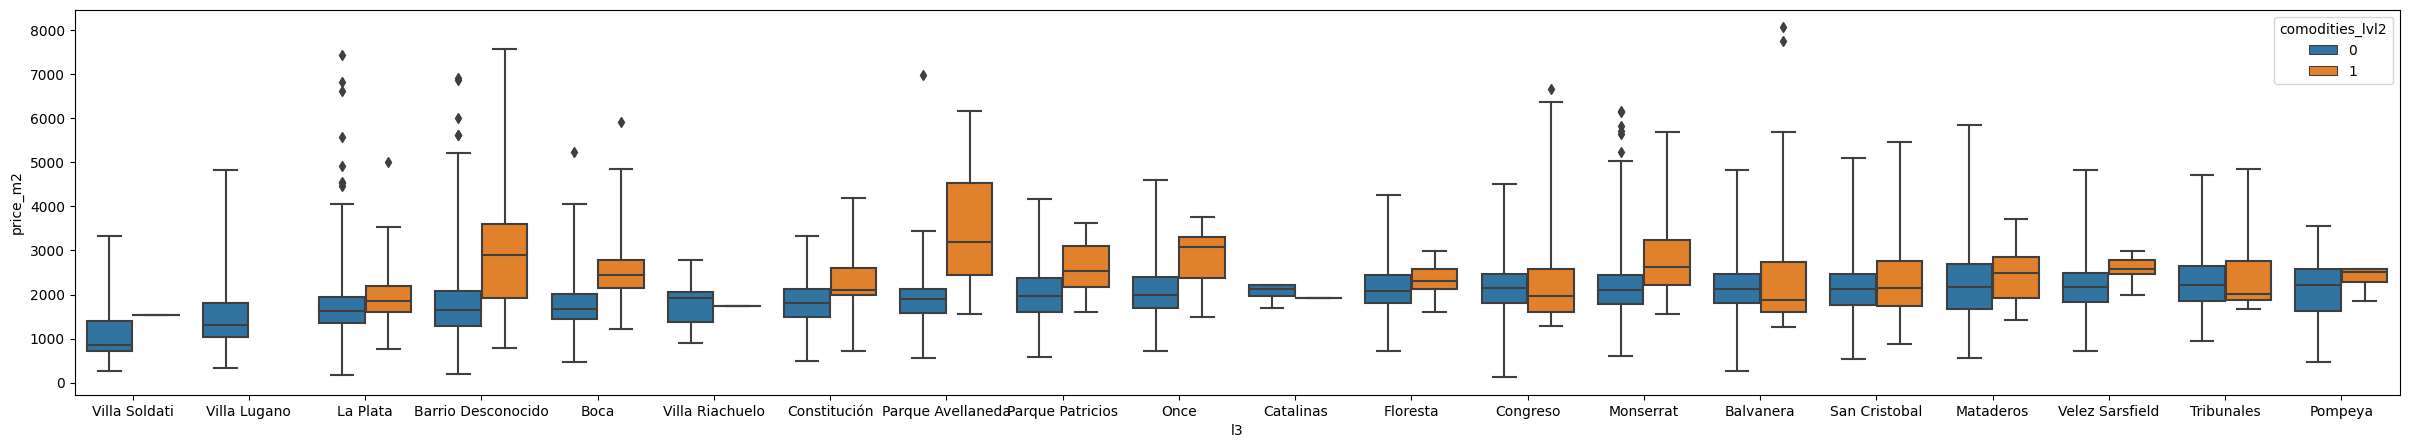

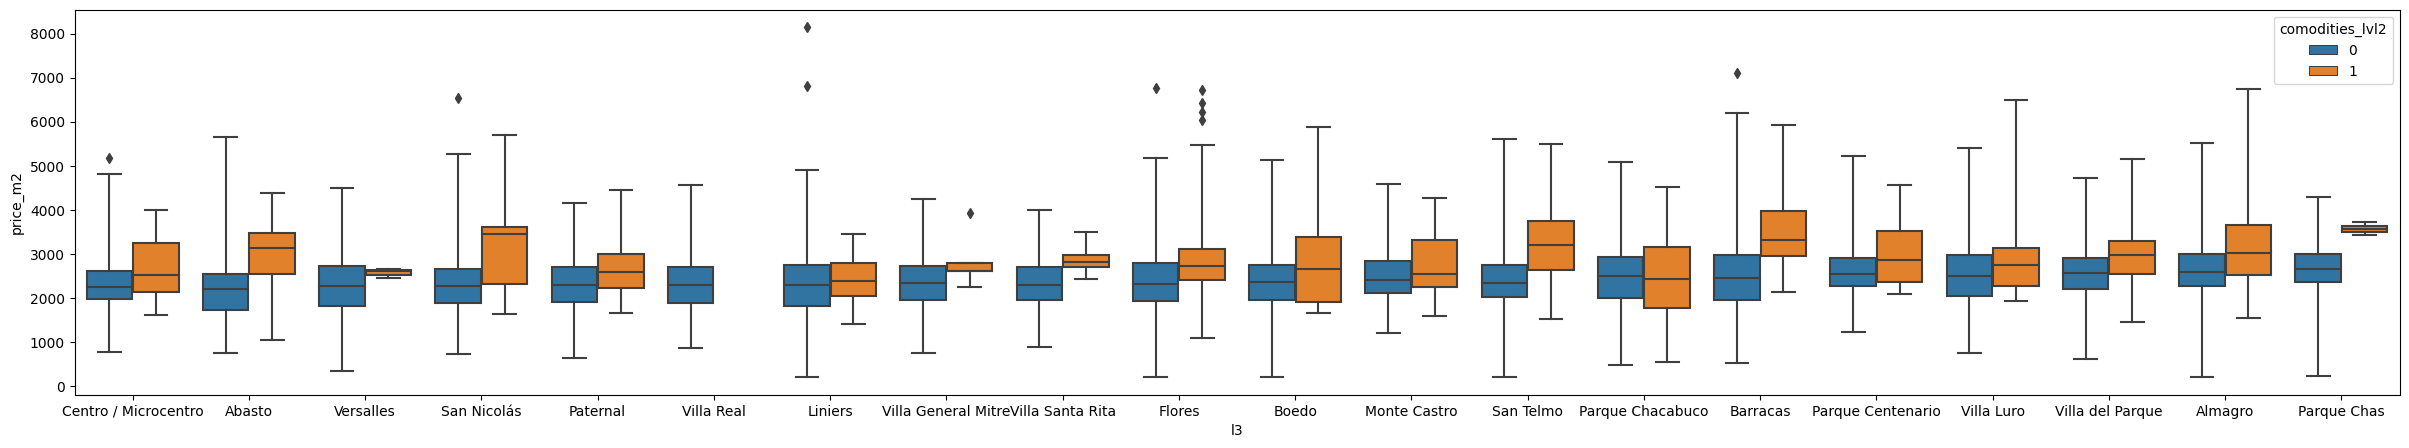

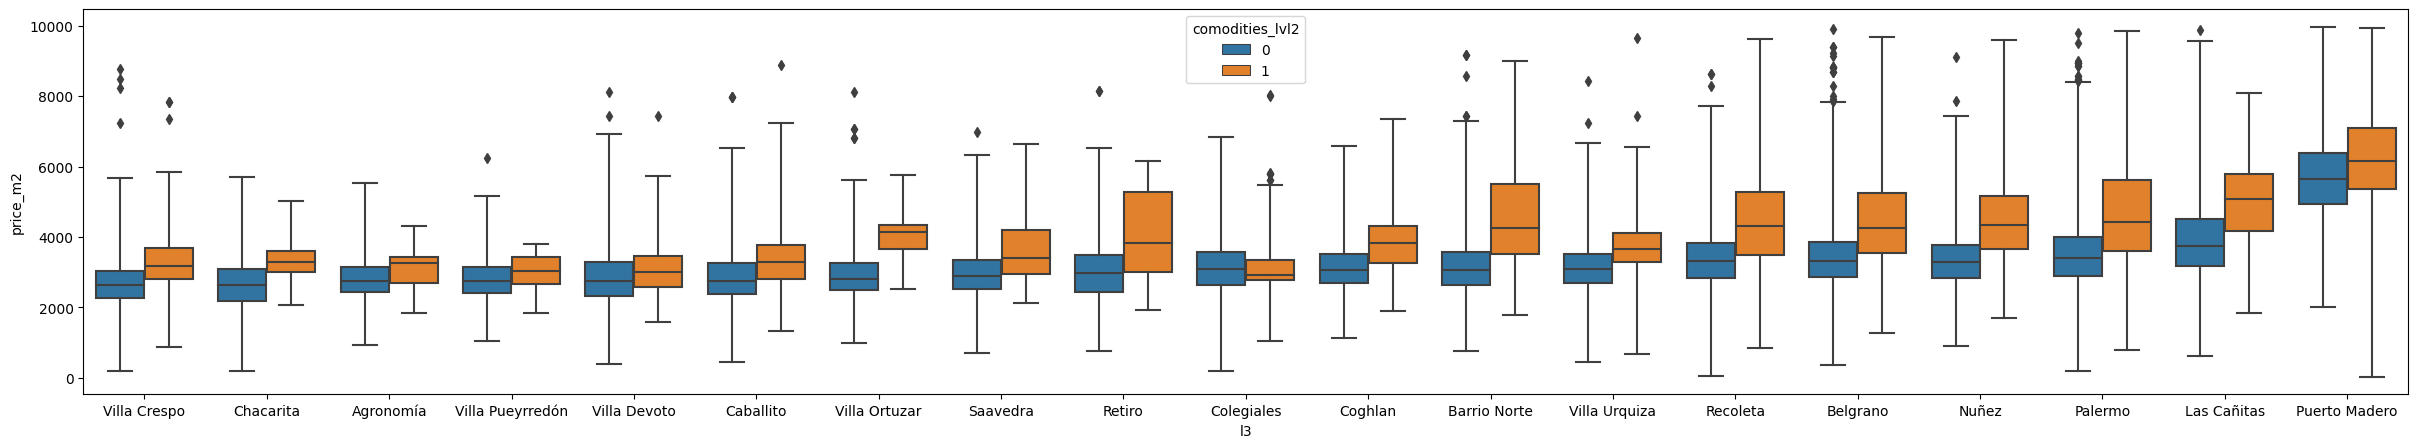

In [ ]:
import seaborn as sns
precio_m2_barrios = df_train.groupby('l3')['price_m2'].agg({'median','count'}).sort_values(by='median') #hay 59 barrios. Voy a hacer boxplots por grupos
barrios1 = precio_m2_barrios[0:20].index.values
barrios2 = precio_m2_barrios[20:40].index.values
barrios3 = precio_m2_barrios[40:].index.values

for barrios in [barrios1,barrios2,barrios3]:
  sns.boxplot(df_train[df_train.l3.isin(barrios)], x='l3', y='price_m2', hue='comodities_lvl2', order =barrios ,whis=4) #hay dptos con precios muy raros. le puse whis 3 (donde los outliers quedan por fuera del IQRx3)
  fig = plt.gcf()
  fig.set_size_inches(30, 5)
  plt.show()

In [ ]:
print(df_train.shape)
# Function to identify outliers based on IQR

# df_train = df_train[~(df_train.description.str.contains('50% al boleto'))]  #sacamos a este que pone el precio como el del 50%

# def identify_outliers(group):
#     q1 = group.quantile(0.25)
#     q3 = group.quantile(0.75)
#     iqr = q3 - q1
#     lower_bound = q1 - 2.5 * iqr
#     upper_bound = q3 +  3.5 * iqr
#     outliers = group[(group < lower_bound) | (group > upper_bound)]
#     return outliers

# # Group by 'group_column' and identify outliers
# outliers = df_train.groupby(['l3'])['price_m2'].apply(identify_outliers)
# df_train = df_train[df_train.price_m2<10000]
# df_train.drop(outliers.reset_index()['id'].values, inplace=True) #sacamos outliers. Revisar colegiales y otros

print(df_train.shape)


(58742, 43)
(58742, 43)


In [124]:
print(df_train.shape)
# Function to identify outliers based on IQR

df_train = df_train[~(df_train.description.fillna('nan').str.contains('50% al boleto'))]  #sacamos a este que pone el precio como el del 50%

def identify_outliers(group):
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 2.5 * iqr
    upper_bound = q3 +  4 * iqr
    outliers = group[(group < lower_bound) | (group > upper_bound)]
    return outliers

# Group by 'group_column' and identify outliers
outliers = df_train.groupby(['l3', 'comodities_lvl2' ])['price_m2'].apply(identify_outliers)

print(outliers.shape)

(84771, 49)
(138,)


In [125]:
df_train.loc[outliers[('Palermo',0)].index].sort_values('price_m2',ascending=False).title_mas_description.values

array(['departamento 25m² 2 ambientes con plantas en gorriti 4500, palermo, palermo viejo, por u$s 245.000 apto profesional. edficio con pileta y sum a estrenar en la mejor zona de palermo viejo  excelente departamento al frente,, con muy buenas terminaciones y gran terraza. muy luminoso.  [ provista por  | código 64001546 ]',
       'duplex de 2 ambientes con 2 terrazas y cochera fija gran 2 ambientes con cochera en palermo hollywood. amplio living-comedor, dormitorio en suite, ba&ntilde;o y toilete, lavadero incorporado.\nposee dos terrazas amplias y parrilla propia. excelente ubicacion.\nposibilidad de hacer un tercer dormitorio.<br />\n - aire acondicionado\\n- parrilla\\n- apto profesional\\n \n ref#475282.',
       'departamento duplex  en venta ubicado en palermo, capital federal ubicado en un hermoso punto que combina la tranquilidad de un barrio, como la energía diaria de una zona de gran expansión comercial y gastronómica. un lugar privilegiado.\nrodeado de tiendas, bares, re

In [129]:
df_train[['latitud','longitud','price','title','description']].duplicated(keep=False).value_counts()

False    76346
True      8425
dtype: int64

In [ ]:
## Agrupamos Barrios

def agrupar_barrios(df_):
  df_['Barrio_Puerto_Madero'] =  df_.l3.isin(['Puerto Madero']).astype('int')
  df_['Barrio_Las_Cañitas'] =  df_.l3.isin(['Las Cañitas']).astype('int')
  df_['Barrio_Palermo_y_otros'] =  df_.l3.isin(['Palermo', 'Nuñez', 'Belgrano', 'Recoleta', 'Barrio Norte']).astype('int')
  df_['Barrios_mas_baratos'] =  df_.l3.isin(['Villa Soldati', 'Villa Lugano', 'Boca', 'Villa Riachuelo', 'Constitucion']).astype('int')


  return df_


df_train = agrupar_barrios(df_train)
df_test = agrupar_barrios(df_test)


In [ ]:
df_test.l3.value_counts(normalize=True).sort_values(ascending=False) #a palermo le voy a hacer un modelo unico porque tiene mucha inportancia...

Palermo                 0.139333
Almagro                 0.082833
Villa Crespo            0.073833
Belgrano                0.068500
Caballito               0.063833
La Plata                0.049500
Recoleta                0.039500
Villa Urquiza           0.037833
Barrio Desconocido      0.028333
Barrio Norte            0.028167
Balvanera               0.024833
Flores                  0.022833
Nuñez                   0.021333
Colegiales              0.018667
Puerto Madero           0.016833
Saavedra                0.015167
Villa Devoto            0.015000
Villa del Parque        0.014500
San Telmo               0.012667
San Cristobal           0.012167
Parque Chacabuco        0.011167
Liniers                 0.010333
Floresta                0.010333
Parque Centenario       0.010167
Paternal                0.009500
Villa Luro              0.009000
Congreso                0.009000
Mataderos               0.008833
San Nicolás             0.008667
Monserrat               0.008500
Chacarita 

### **Price/m2 del alrededor**

In [ ]:
df_train_copy2 = df_train.copy()
df_test_copy2 = df_test.copy()


In [101]:
from scipy.spatial.distance import cdist

len_df = len(df_train) + len(df_test)


def calculate_median_price_per_sqm(latitude, longitude, Nmayor, Nmenor):
    # Calculate the Euclidean distance between the target house and all other houses
    distances = cdist([[latitude, longitude]], df_train[['latitud', 'longitud']], metric='euclidean')[0]

    # Sort the distances and get the indices of the nearest N houses
    tuples = sorted(zip(distances, df_train.index.values))
    # Retrieve the nearest IDs
    nearest_ids_Nmayor = [tup[1] for tup in tuples if tup[0]>0][:Nmayor]
    nearest_ids_Nmenor = nearest_ids_Nmayor[:Nmenor]


    # Calculate the price per square meter for each nearest house
    price_m2_Nmayor = df_train.loc[nearest_ids_Nmayor, 'price_m2']
    median_price_m2_Nmayor = price_m2_Nmayor.median()

    price_m2_Nmenor = df_train.loc[nearest_ids_Nmenor, 'price_m2']
    median_price_m2_Nmenor = price_m2_Nmenor.median()

    return median_price_m2_Nmayor, median_price_m2_Nmenor



# Create a new column to store the median price per square meter
# df_train['median_price_m2_N50'] = None
# df_train['median_price_m2_N10'] = None

i=1

# Iterate over each house
for index, row in df_train.iterrows():
  if (np.isnan(row.median_price_m2_N50)) or (np.isnan(row.median_price_m2_N10)):

    # Get the latitude and longitude of the house
    latitude = row['latitud']
    longitude = row['longitud']

    # Calculate the median price per square meter of the nearest N houses
    median_price_ = calculate_median_price_per_sqm(latitude, longitude, 50,10)
    median_price_N50 = median_price_[0]
    median_price_N10 = median_price_[1]

    # Assign the calculated median price per square meter to the corresponding row in the DataFrame
    df_train.at[index, 'median_price_m2_N50'] = median_price_N50
    df_train.at[index, 'median_price_m2_N10'] = median_price_N10

    print("Progreso:", round(i/len_df,3)*100,"%")
  i=i+1

# df_test['median_price_m2_N50'] = None
# df_test['median_price_m2_N10'] = None

for index, row in df_test.iterrows():

  if (np.isnan(row.median_price_m2_N50)) or (np.isnan(row.median_price_m2_N10)):
    # Get the latitude and longitude of the house
    latitude = row['latitud']
    longitude = row['longitud']

    # Calculate the median price per square meter of the nearest N houses
    median_price_ = calculate_median_price_per_sqm(latitude, longitude, 50,10)
    median_price_N50 = median_price_[0]
    median_price_N10 = median_price_[1]

    # Assign the calculated median price per square meter to the corresponding row in the DataFrame
    df_test.at[index, 'median_price_m2_N50'] = median_price_N50
    df_test.at[index, 'median_price_m2_N10'] = median_price_N10

    print("Progreso:", round(i/len_df,3)*100,"%")
  i=i+1


Se truncaron las últimas líneas 5000 del resultado de transmisión.
Progreso: 58.099999999999994 %
Progreso: 58.099999999999994 %
Progreso: 58.099999999999994 %
Progreso: 58.099999999999994 %
Progreso: 58.099999999999994 %
Progreso: 58.099999999999994 %
Progreso: 58.099999999999994 %
Progreso: 58.199999999999996 %
Progreso: 58.199999999999996 %
Progreso: 58.199999999999996 %
Progreso: 58.199999999999996 %
Progreso: 58.199999999999996 %
Progreso: 58.199999999999996 %
Progreso: 58.199999999999996 %
Progreso: 58.199999999999996 %
Progreso: 58.199999999999996 %
Progreso: 58.3 %
Progreso: 58.3 %
Progreso: 58.3 %
Progreso: 58.3 %
Progreso: 58.3 %
Progreso: 58.3 %
Progreso: 58.3 %
Progreso: 58.3 %
Progreso: 58.3 %
Progreso: 58.3 %
Progreso: 58.3 %
Progreso: 58.3 %
Progreso: 58.3 %
Progreso: 58.4 %
Progreso: 58.4 %
Progreso: 58.4 %
Progreso: 58.4 %
Progreso: 58.4 %
Progreso: 58.4 %
Progreso: 58.4 %
Progreso: 58.4 %
Progreso: 58.4 %
Progreso: 58.4 %
Progreso: 58.4 %
Progreso: 58.5 %
Progreso: 58

In [103]:
df_train.to_csv(DIR + "df_train_20230612.csv.zip")
df_test.to_csv(DIR + "df_test_20230612.csv.zip")


In [100]:
# DIR = "/content/drive/MyDrive/Colab Notebooks/Data Mining/TP - Individual/"

# df_train = pd.read_csv(DIR + "df_train_20230612.csv.zip", index_col="id")
# df_test = pd.read_csv(DIR + "df_test_20230612.csv.zip", index_col="id")

In [ ]:
print(df_train[['price','surface_covered','price_m2', 'median_price_m2_N50', 'median_price_m2_N10' ]].isna().sum())
df_train[['price','surface_covered','price_m2', 'median_price_m2_N50', 'median_price_m2_N10' ]]

In [107]:
# Funcion de limpieza (usada en la siguiente sección) que usa y_train
def limpiar_fold(X_train, y_train, X_test):
    ## TODO: limpiar los datos

    return (X_train, y_train, X_test)

In [108]:
df_train.columns

Index(['start_date', 'end_date', 'longitud', 'latitud', 'l2', 'l3', 'l4',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'price_period', 'title', 'description',
       'property_type', 'end_date_null', 'date_Q', 'barrio_faltante',
       'title_mas_description', 'latitud_faltante', 'longitud_faltante',
       'rooms_na', 'bedrooms_na', 'bathrooms_na', 'surface_total_na',
       'surfaced_covered_na', 'surface_uncovered', 'price_m2', 'is_PH',
       'espacio_verde', 'comodities_lvl2', 'comodities_lvl1',
       'comodities_lvl0', 'ubicacion', 'cochera_fl', 'equipado', 'nuevo_fl',
       'seguridad_fl', 'balcon_fl', 'pozo_fl', 'Barrio_Puerto_Madero',
       'Barrio_Las_Cañitas', 'Barrio_Palermo_y_otros', 'Barrios_mas_baratos',
       'median_price_m2_N50', 'median_price_m2_N10'],
      dtype='object')

In [105]:
df_backup_train = df_train.copy()
df_backup_test = df_test.copy()

# df_train = df_backup_train.copy()
# df_test = df_backup_test.copy()


# Entrenamiento del modelo

In [109]:
print(df_train.columns)
COLUMNAS_A_USAR =  ['rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered',  'surface_uncovered', 'price_m2', 'is_PH',
       'espacio_verde', 'comodities_lvl2', 'comodities_lvl1',
       'comodities_lvl0', 'ubicacion', 'cochera_fl', 'equipado', 'nuevo_fl',
       'seguridad_fl', 'balcon_fl', 'pozo_fl', 'Barrio_Puerto_Madero',
       'Barrio_Las_Cañitas', 'Barrio_Palermo_y_otros', 'Barrios_mas_baratos', 'latitud','longitud', 'median_price_m2_N50']

COLUMNAS_A_USAR_LAPLATA = ['rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered',  'surface_uncovered', 'price_m2', 'is_PH',
       'espacio_verde', 'comodities_lvl2', 'comodities_lvl1',
       'comodities_lvl0', 'ubicacion', 'cochera_fl', 'equipado', 'nuevo_fl',
       'seguridad_fl', 'balcon_fl', 'pozo_fl', 'latitud','longitud', 'median_price_m2_N50']

COLUMNAS_A_USAR_PALERMO = ['rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered',  'surface_uncovered', 'price_m2', 'is_PH',
       'espacio_verde', 'comodities_lvl2', 'comodities_lvl1',
       'comodities_lvl0', 'ubicacion', 'cochera_fl', 'equipado', 'nuevo_fl',
       'seguridad_fl', 'balcon_fl', 'pozo_fl', 'latitud','longitud', 'median_price_m2_N50']

Index(['start_date', 'end_date', 'longitud', 'latitud', 'l2', 'l3', 'l4',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'price_period', 'title', 'description',
       'property_type', 'end_date_null', 'date_Q', 'barrio_faltante',
       'title_mas_description', 'latitud_faltante', 'longitud_faltante',
       'rooms_na', 'bedrooms_na', 'bathrooms_na', 'surface_total_na',
       'surfaced_covered_na', 'surface_uncovered', 'price_m2', 'is_PH',
       'espacio_verde', 'comodities_lvl2', 'comodities_lvl1',
       'comodities_lvl0', 'ubicacion', 'cochera_fl', 'equipado', 'nuevo_fl',
       'seguridad_fl', 'balcon_fl', 'pozo_fl', 'Barrio_Puerto_Madero',
       'Barrio_Las_Cañitas', 'Barrio_Palermo_y_otros', 'Barrios_mas_baratos',
       'median_price_m2_N50', 'median_price_m2_N10'],
      dtype='object')


## Territorio de Aprendizaje Automático
☢☢☢☢☢☢ Se mira y no se toca ☢☢☢☢☢☢☢

In [110]:
def modelo_cross_validation(X,y):

  # Creamos el modelo
  reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)

  # Partimos en entrenamiento+prueba y validación
  X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

  scores_train = []
  scores_test = []
  # Validación cruzada, 10 folds, shuffle antes
  kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
  for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
      X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

      X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

      # Entrenamos el modelo
      reg.fit(X_train, y_train)

      # Predecimos en train
      y_pred = reg.predict(X_train)

      # Medimos la performance de la predicción en test
      score_train = sk.metrics.mean_squared_error(y_train, y_pred,  squared=False)
      scores_train.append(score_train)

      # Predecimos en test
      y_pred = reg.predict(X_test)

      # Medimos la performance de la predicción en test
      score_test = sk.metrics.mean_squared_error(y_test, y_pred, squared=False)
      scores_test.append(score_test)

      print(f"{fold=}, {score_train=} {score_test=}")


  print(f"Train scores mean={pd.Series(scores_train).mean()}, std={pd.Series(scores_train).std()}")
  print(f"Test scores mean={pd.Series(scores_test).mean()}, std={pd.Series(scores_test).std()}")



In [111]:
# Datos para probar

print("Datos La Plata", df_train[df_train.l3=='La Plata'].shape)
print("Datos Palermo", df_train[df_train.l3=='Palermo'].shape)
print("Datos Otros", df_train[~((df_train.l3=='La Plata') | (df_train.l3=='Palermo'))].shape)
print("Datos Totales", df_train.shape)


df_train_laplata = df_train[df_train.l3=='La Plata'][COLUMNAS_A_USAR_LAPLATA]
df_test_laplata = df_test[df_test.l3=='La Plata'][df_train_laplata.columns.drop('price_m2')]

df_train_palermo = df_train[df_train.l3=='Palermo'][COLUMNAS_A_USAR_PALERMO]
df_test_palermo = df_test[df_test.l3=='Palermo'][df_train_palermo.columns.drop('price_m2')]
df_train_otros = df_train[~((df_train.l3=='La Plata') | (df_train.l3=='Palermo'))][COLUMNAS_A_USAR]
df_test_otros = df_test[~((df_test.l3=='La Plata') | (df_test.l3=='Palermo'))][df_train_otros.columns.drop('price_m2')]

for df_modelo in [df_train_laplata,df_train_palermo, df_train_otros ]:
  print("\n")
  X = df_modelo[df_modelo.columns.drop('price_m2')]
  y = df_modelo['price_m2']
  modelo_cross_validation(X,y)

Datos La Plata (4575, 49)
Datos Palermo (10900, 49)
Datos Otros (69296, 49)
Datos Totales (84771, 49)


fold=0, score_train=419.2628441522363 score_test=542.6959643992604
fold=1, score_train=420.4648552078742 score_test=495.94538237701767
fold=2, score_train=426.4082569158627 score_test=420.18888704242397
fold=3, score_train=419.43797402624074 score_test=476.637594124891
fold=4, score_train=424.36778969503087 score_test=453.11403843367714
fold=5, score_train=427.1802709650468 score_test=420.33568432046985
fold=6, score_train=423.21403565800694 score_test=483.28922151467947
fold=7, score_train=426.8780419816809 score_test=411.19330220951304
fold=8, score_train=427.0088151070822 score_test=417.0872307998718
fold=9, score_train=424.07948378711416 score_test=445.8504852144911
Train scores mean=423.8302367496176, std=3.1529708258977234
Test scores mean=456.6337790436295, std=42.77328265550173


fold=0, score_train=875.7047896210244 score_test=887.6355201512077
fold=1, score_train=872.656241

# Predicción para kaggle


In [112]:
def prediccion_para_kaggle(df_train_modelo, df_test_modelo):

  reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)

  ## Datos a predecir
  X = df_train_modelo[df_train_modelo.columns.drop('price_m2')]
  y = df_train_modelo['price_m2']
  X_prueba = df_test_modelo[df_train_modelo.columns.drop('price_m2')] # cuidado:

  # Entrenamos el modelo con todos los datos
  reg.fit(X, y)

  # Predecimos
  df_test_modelo['price_m2'] = reg.predict(X_prueba)
  df_test_modelo['price'] =df_test_modelo['price_m2'] * df_test_modelo['surface_covered']

  print(pd.DataFrame(zip(df_train_modelo.columns.drop('price_m2'), reg.feature_importances_), columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False).round(2))

  return df_test_modelo['price']

In [113]:
price_laplata = prediccion_para_kaggle(df_train_laplata, df_test_laplata)
price_palermo = prediccion_para_kaggle(df_train_palermo, df_test_palermo)
price_otros = prediccion_para_kaggle(df_train_otros, df_test_otros)

x = pd.concat([price_laplata, price_palermo, price_otros]).sort_index()
x.to_csv('solucion.csv', index=True)

                 column  feature_importance
20  median_price_m2_N50                0.28
12           cochera_fl                0.20
4       surface_covered                0.14
0                 rooms                0.08
18              latitud                0.06
6                 is_PH                0.04
3         surface_total                0.03
19             longitud                0.03
5     surface_uncovered                0.03
9       comodities_lvl1                0.03
10      comodities_lvl0                0.02
17              pozo_fl                0.01
8       comodities_lvl2                0.01
15         seguridad_fl                0.01
1              bedrooms                0.01
7         espacio_verde                0.01
14             nuevo_fl                0.00
16            balcon_fl                0.00
11            ubicacion                0.00
2             bathrooms                0.00
13             equipado                0.00
                 column  feature

In [114]:
x.shape

(6000,)

In [115]:
df_test.shape

(6000, 48)

In [ ]:
df_train_laplata.columns

Index(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'end_date_null', 'surface_uncovered', 'price_m2', 'is_PH',
       'espacio_verde', 'comodities_lvl2', 'comodities_lvl1',
       'comodities_lvl0', 'ubicacion', 'cochera_fl', 'equipado', 'nuevo_fl',
       'seguridad_fl', 'balcon_fl', 'pozo_fl', 'latitud_faltante',
       'longitud_faltante', 'latitud', 'longitud'],
      dtype='object')

In [ ]:
df_train_palermo.columns

Index(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'end_date_null', 'surface_uncovered', 'price_m2', 'is_PH',
       'espacio_verde', 'comodities_lvl2', 'comodities_lvl1',
       'comodities_lvl0', 'ubicacion', 'cochera_fl', 'equipado', 'nuevo_fl',
       'seguridad_fl', 'balcon_fl', 'pozo_fl', 'latitud_faltante',
       'longitud_faltante', 'latitud', 'longitud', 'price'],
      dtype='object')